In [2]:
import pandas as pd
from matplotlib import pyplot as plt
cpi=pd.read_csv("inflation-of-consumer-prices.csv")
cpi.head()

,Entity,Code,Year,"Inflation, consumer prices (annual %)"
0,Australia,AUS,1960,3.728814
1,Austria,AUT,1960,1.945749
2,Belgium,BEL,1960,0.299467
3,Bolivia,BOL,1960,11.533153
4,Burkina Faso,BFA,1960,7.788162


           infl      years
23     1.779878 1960-01-01
89     1.695213 1961-01-01
157    3.632215 1962-01-01
227    2.946161 1963-01-01
297   13.355261 1964-01-01
372    9.474758 1965-01-01
455   10.801848 1966-01-01
543   13.062202 1967-01-01
634    3.237413 1968-01-01
727   -0.584137 1969-01-01
822    5.092262 1970-01-01
920    3.079939 1971-01-01
1020   6.442098 1972-01-01
1123  16.940817 1973-01-01
1227  28.598734 1974-01-01
1333   5.748430 1975-01-01
1442  -7.633948 1976-01-01
1553   8.307470 1977-01-01
1665   2.523049 1978-01-01
1776   6.275683 1979-01-01


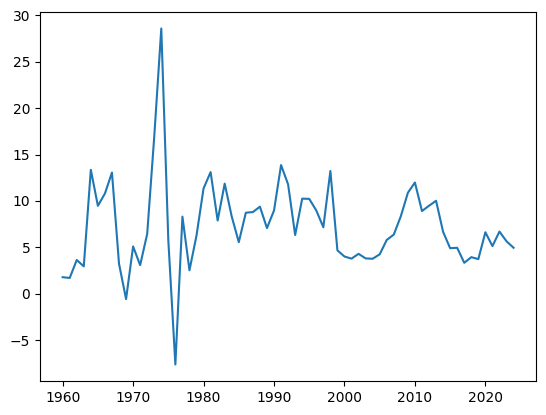

In [3]:

country="India"
data=cpi[cpi["Entity"]==country].sort_values("Year")
cp=data['Inflation, consumer prices (annual %)']
years = pd.to_datetime(data["Year"], format="%Y")
cp.head()
cp.tail()
plt.plot(years, cp)
values=pd.DataFrame({"infl":cp,"years":years})
print(values.iloc[:20])





In [4]:
from statsmodels.tsa.stattools import adfuller

diffrence=cp.dropna()
result1=adfuller(diffrence)
print(result1[0])
print(result1[1])
print({k: round(v, 2) for k, v in result1[4].items()}) 

if result1[1]<0.05:
    print("ok")
else:
    print("not ok")

-5.3051337383864885
5.343157742930871e-06
{'1%': np.float64(-3.54), '5%': np.float64(-2.91), '10%': np.float64(-2.59)}
ok


<function plot_pacf at 0x000001D973DC20C0>
-------------


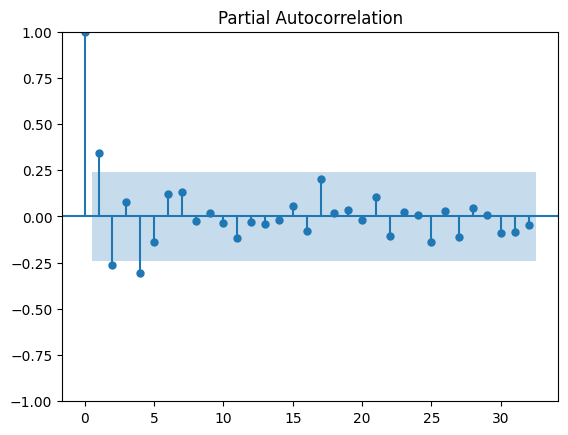

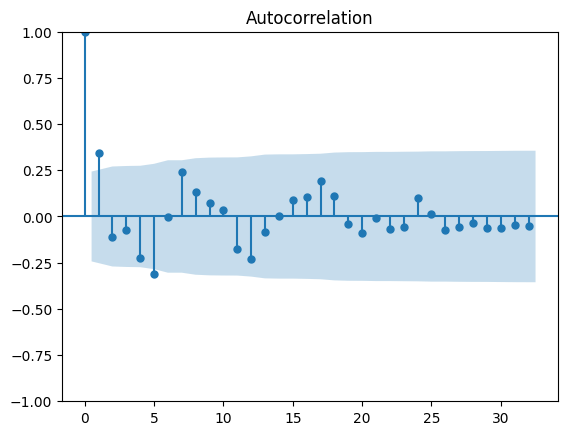

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
plot_pacf(cp,lags=32)
plot_acf(cp,lags=32)
print(plot_pacf)
print("-------------")
plt.show(plot_acf)





p=1,2,4 q=1,5 (1,0 1) (1,0,5)(2,0,1) (2,0,5 ) (4,0,1 )(4,0,5)

In [8]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(cp,order=(0,1,0))
res=model.fit()
print(res.summary())

                                         SARIMAX Results                                         
Dep. Variable:     Inflation, consumer prices (annual %)   No. Observations:                   65
Model:                                    ARIMA(0, 1, 0)   Log Likelihood                -199.312
Date:                                   Sat, 20 Sep 2025   AIC                            400.624
Time:                                           17:25:05   BIC                            402.783
Sample:                                                0   HQIC                           401.475
                                                    - 65                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        29.6850      2.865     10.361      0.000    

c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import rmse
import numpy as np
data["Year"]=pd.to_datetime(data["Year"], format="%Y")
X=data[["Year"]]  
y=data.set_index("Year")["Inflation, consumer prices (annual %)"].dropna()
p=[1,2,4]
d=[0]
q=[1, 5]
results=[]
for pv in p:
    for dv in d:
        for qv in q:
            X_train,X_test,y_train,y_test=train_test_split(X, y,train_size=0.8,shuffle=False)
            model=ARIMA(y_train,order=(pv,dv,qv))   
            result=model.fit()
            start=len(y_train)
            end=len(y_train)+len(y_test)-1
            predictions = result.predict(start=start, end=end, typ="levels")
            predictions.index = X_test["Year"].values
            fitted_vals=result.fittedvalues
            fitted_vals.index=y_train.index

            trainr = rmse(y_train,fitted_vals)
            testr = rmse(y_test,predictions)
            diff=trainr-testr
            
            results.append((pv,dv,qv,trainr,testr,diff))
            #print(f"Order=({pv},{dv},{qv})Train RMSE:{train_rmse}Test RMSE:{test_rmse:}")
df_results = pd.DataFrame(results,columns=["p","d","q","Trainrmse","TestrmseE","difference"])
print(df_results)

c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\leston\miniconda3\envs\time\Lib\site-pa

   p  d  q  Trainrmse  TestrmseE  difference
0  1  0  1   4.674121   2.672005    2.002116
1  1  0  5   4.393813   2.919707    1.474105
2  2  0  1   4.652232   2.712875    1.939357
3  2  0  5   4.382118   2.797170    1.584947
4  4  0  1   4.367256   2.995334    1.371923
5  4  0  5   4.225585   3.353356    0.872229


c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [58]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import rmse
import numpy as np
data["Year"]=pd.to_datetime(data["Year"], format="%Y")
X=data[["Year"]]  
y=data.set_index("Year")["Inflation, consumer prices (annual %)"].dropna()
p=[1,2,4]
d=[0]
q=[1,5]

results=[]
train_test_sizes=[[0.60,0.1],[0.70,0.1],[ 0.80,0.1],[0.90,0.1]]

  
for pv in p:
    for dv in d:
        for qv in q:
            for size1,size2 in train_test_sizes:
                temp=[]
                X_train,X_test,y_train,y_test=train_test_split(X, y,train_size=size1,test_size=size2,shuffle=False)
                model=ARIMA(y_train,order=(pv,dv,qv))   
                result=model.fit()
                start=len(y_train)
                end=len(y_train)+len(y_test)-1
                predictions = result.predict(start=start, end=end, typ="levels")
                predictions.index = X_test["Year"].values
                fitted_vals=result.fittedvalues
                fitted_vals.index=y_train.index

                trainr=rmse(y_train,fitted_vals)
                testr=rmse(y_test,predictions)
                diff=trainr-testr
                results.append((pv,dv,qv,trainr,testr,diff))
                temp.append((trainr,testr))
                print(trainr)
                print(testr)
                print()
            temp_arr = np.array(temp)
            mean_train = temp_arr[:,0].mean()
            std_train  = temp_arr[:,0].std()
            mean_test  = temp_arr[:,1].mean()
            std_test   = temp_arr[:,1].std()
            print(f"Summary for ARIMA({pv},{dv},{qv}):")
            print(f"  Mean Train RMSE: {mean_train:.4f}, Std: {std_train:.4f}")
            print(f"  Mean Test  RMSE: {mean_test:.4f}, Std: {std_test:.4f}")
            print("-"*50)

            #print(f"Order=({pv},{dv},{qv})Train RMSE:{train_rmse}Test RMSE:{test_rmse:}")
# df_results = pd.DataFrame(results,columns=["p","d","q","Trainrmse","TestrmseE","difference"])
# print(df_results)
# print()

5.080829007819806
4.530314415058597

4.961345338183285
2.540169435937051

4.674121135680682
2.8771278445808735

4.478991716660696
2.31383506381252

Summary for ARIMA(1,0,1):
  Mean Train RMSE: 4.4790, Std: 0.0000
  Mean Test  RMSE: 2.3138, Std: 0.0000
--------------------------------------------------
4.711366061267024
5.203304925530117

4.636115338162312
3.1647088044848215

4.393812759949248
3.089788955168408

4.2237223375875725
4.036572385185575

Summary for ARIMA(1,0,5):
  Mean Train RMSE: 4.2237, Std: 0.0000
  Mean Test  RMSE: 4.0366, Std: 0.0000
--------------------------------------------------
5.081978672817012
4.433888258658578

4.934314521610147
2.6101149576379292

4.652232274707491
2.9410392804414704

4.463453721107895
2.4392182354876373

Summary for ARIMA(2,0,1):
  Mean Train RMSE: 4.4635, Std: 0.0000
  Mean Test  RMSE: 2.4392, Std: 0.0000
--------------------------------------------------
4.375910059306026
4.760373386620176

4.580317833933438
3.680749033549756

4.3821178499

In [50]:
temp=[]
results=[]
train_test_sizes=[[0.60,0.1],[0.70,0.1],[0.80,0.1],[0.90,0.1]]
for pv in p:
    for dv in d:
        for qv in q:
            temp = []   # reset for each (p,d,q)
            for size1,size2 in train_test_sizes:
                X_train,X_test,y_train,y_test=train_test_split(
                    X, y,train_size=size1,test_size=size2,shuffle=False
                )
                model=ARIMA(y_train,order=(pv,dv,qv))   
                result=model.fit()
                start=len(y_train)
                end=len(y_train)+len(y_test)-1
                predictions = result.predict(start=start, end=end)
                predictions.index = X_test["Year"].values
                fitted_vals=result.fittedvalues
                fitted_vals.index=y_train.index

                trainr=rmse(y_train,fitted_vals)
                testr=rmse(y_test,predictions)
                diff=trainr-testr
                results.append((pv,dv,qv,trainr,testr,diff))
                temp.append((trainr,testr))

                print(trainr)
                print(testr)
                print()

            # ⬇️ add mean & std summary after finishing all sizes for this (p,d,q)
            temp_arr = np.array(temp)
            mean_train = temp_arr[:,0].mean()
            std_train  = temp_arr[:,0].std()
            mean_test  = temp_arr[:,1].mean()
            std_test   = temp_arr[:,1].std()

            print(f"Summary for ARIMA({pv},{dv},{qv}):")
            print(f"  Mean Train RMSE: {mean_train:.4f}, Std: {std_train:.4f}")
            print(f"  Mean Test  RMSE: {mean_test:.4f}, Std: {std_test:.4f}")
            print("-"*50)


5.080829007819806
4.530314415058597

4.961345338183285
2.540169435937051

4.674121135680682
2.8771278445808735

4.478991716660696
2.31383506381252

Summary for ARIMA(1,0,1):
  Mean Train RMSE: 4.7988, Std: 0.2365
  Mean Test  RMSE: 3.0654, Std: 0.8692
--------------------------------------------------
4.711366061267024
5.203304925530117

4.636115338162312
3.1647088044848215

4.393812759949248
3.089788955168408

4.2237223375875725
4.036572385185575

Summary for ARIMA(1,0,5):
  Mean Train RMSE: 4.4913, Std: 0.1940
  Mean Test  RMSE: 3.8736, Std: 0.8532
--------------------------------------------------
5.081978672817012
4.433888258658578

4.934314521610147
2.6101149576379292

4.652232274707491
2.9410392804414704

4.463453721107895
2.4392182354876373

Summary for ARIMA(2,0,1):
  Mean Train RMSE: 4.7830, Std: 0.2406
  Mean Test  RMSE: 3.1061, Std: 0.7876
--------------------------------------------------
4.375910059306026
4.760373386620176

4.580317833933438
3.680749033549756

4.3821178499

In [49]:
import warnings
warnings.filterwarnings("ignore")   # Suppress statsmodels warnings

from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# --- Prepare data ---
data["Year"] = pd.to_datetime(data["Year"], format="%Y")
X = data[["Year"]]  
y = data.set_index("Year")["Inflation, consumer prices (annual %)"].dropna()

# --- ARIMA parameter grid ---
p = [1, 2, 4]
d = [0]
q = [1, 5]

# --- Train/test splits ---
train_test_sizes=[[0.60,0.1],[0.70,0.1],[ 0.80,0.1],[0.90,0.1]]

results = []

# --- Run experiments ---
for pv in p:
    for dv in d:
        for qv in q:
           
            
            temp_results = []  # store results for this (p,d,q)
            
            for size,size2 in train_test_sizes:
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, train_size=size,test_size=size2 ,shuffle=False
                )

                # Fit ARIMA model
                model = ARIMA(y_train, order=(pv, dv, qv))
                result = model.fit()

                # Forecast
                start = len(y_train)
                end = len(y_train) + len(y_test) - 1
                predictions = result.predict(start=start, end=end)
                predictions.index = X_test["Year"].values

                # Fitted values on train
                fitted_vals = result.fittedvalues
                fitted_vals.index = y_train.index

                # RMSEs
                trainr = rmse(y_train, fitted_vals)
                testr = rmse(y_test, predictions)
                diff = trainr - testr

                results.append((pv, dv, qv, size, trainr, testr, diff))
                temp_results.append((trainr, testr))

                print(f"Train size={size:.2f} | Train RMSE={trainr:.4f} | Test RMSE={testr:.4f}")

           
            temp_df = pd.DataFrame(temp_results, columns=["TrainRMSE", "TestRMSE"])
            mean_train, std_train = temp_df["TrainRMSE"].mean(), temp_df["TrainRMSE"].std()
            mean_test, std_test = temp_df["TestRMSE"].mean(), temp_df["TestRMSE"].std()

            print(f"\nSummary for ARIMA({pv},{dv},{qv}):")
            print(f"  Mean Train RMSE = {mean_train:.4f} | Std = {std_train:.4f}")
            print(f"  Mean Test  RMSE = {mean_test:.4f} | Std = {std_test:.4f}")
            print("-" * 50)




Train size=0.60 | Train RMSE=5.0808 | Test RMSE=4.5303
Train size=0.70 | Train RMSE=4.9613 | Test RMSE=2.5402
Train size=0.80 | Train RMSE=4.6741 | Test RMSE=2.8771
Train size=0.90 | Train RMSE=4.4790 | Test RMSE=2.3138

Summary for ARIMA(1,0,1):
  Mean Train RMSE = 4.7988 | Std = 0.2731
  Mean Test  RMSE = 3.0654 | Std = 1.0037
--------------------------------------------------
Train size=0.60 | Train RMSE=4.7114 | Test RMSE=5.2033
Train size=0.70 | Train RMSE=4.6361 | Test RMSE=3.1647
Train size=0.80 | Train RMSE=4.3938 | Test RMSE=3.0898
Train size=0.90 | Train RMSE=4.2237 | Test RMSE=4.0366

Summary for ARIMA(1,0,5):
  Mean Train RMSE = 4.4913 | Std = 0.2240
  Mean Test  RMSE = 3.8736 | Std = 0.9852
--------------------------------------------------
Train size=0.60 | Train RMSE=5.0820 | Test RMSE=4.4339
Train size=0.70 | Train RMSE=4.9343 | Test RMSE=2.6101
Train size=0.80 | Train RMSE=4.6522 | Test RMSE=2.9410
Train size=0.90 | Train RMSE=4.4635 | Test RMSE=2.4392

Summary for ARI

c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


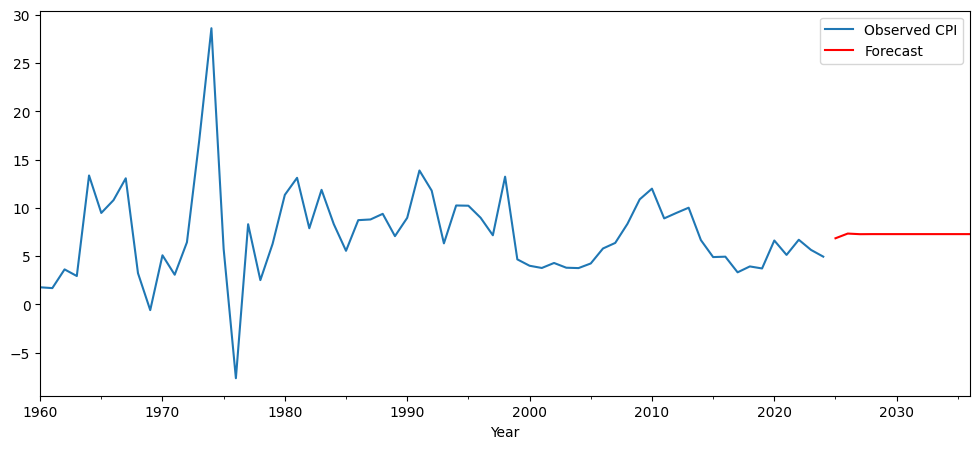

In [32]:
model=ARIMA(y, order=(1,0,1))
result=model.fit()
forecast=result.predict(start=len(y),end=len(y)+12-1,)
last_year=y.index[-1].year
forecast.index=pd.date_range(start=str(last_year+1), periods=12,freq="YE")
#inflation=forecast.pct_change()*100
#inflation.iloc[0] = ((forecast.iloc[0]-y.iloc[-1])/y.iloc[-1])*100
plt.figure(figsize=(12,5))
y.plot(label="Observed CPI")
forecast.plot(label="Forecast", color="red")
#plt.title(f"ARIMA Forecast for {country}")
#plt.xlabel("Year")
#plt.ylabel("CPI (2010=100)")
plt.legend()
plt.show()


In [90]:
forecast_df=pd.DataFrame({"Year":forecast.index,"Forecasted CPI":forecast.values})
print(forecast_df)

         Year  Forecasted CPI
0  2025-12-31        6.854117
1  2026-12-31        7.341141
2  2027-12-31        7.276970
3  2028-12-31        7.285425
4  2029-12-31        7.284311
5  2030-12-31        7.284458
6  2031-12-31        7.284438
7  2032-12-31        7.284441
8  2033-12-31        7.284441
9  2034-12-31        7.284441
10 2035-12-31        7.284441
11 2036-12-31        7.284441
